In [1]:
################################################################################################################################
#
# LSTM - JANSEN - LNDIFF - MONTHLY
#
################################################################################################################################

#-------------------------------------------------------------------------------------------------------------------------------
# 
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# ENVIRONMENT: LIBRARIES, SETTINGS
#===============================================================================================================================
#pip install pandas-datareader

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import sklearn
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow import keras

In [2]:
#===============================================================================================================================
# ENVIRONMENT: HARDWARE
#===============================================================================================================================
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
#===============================================================================================================================
# ENVIRONMENT: CONFIG
#===============================================================================================================================
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
#===============================================================================================================================
# DATA: INPUT/OUTPUT
#===============================================================================================================================
input_path = Path('Data', 'Input')
results_path = Path('Data\Output', 'LSTM-Jansen-LnDiff-Montlhy')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [7]:
#===============================================================================================================================
# DATA: SETTINGS
#===============================================================================================================================
seriesId='IBOV-monthly'
#ESCALA = 'log'  #'minmax' 
#EPOCAS = 100
#LOTE = 12
#NEURONS = 32
window_size=6

#===============================================================================================================================
# DATA: READ
#===============================================================================================================================
df = pd.read_csv(seriesId+'.csv')
#df.drop(['Open','Low','High', 'Qt'], axis='columns', inplace=True )
#df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
#df.set_index('Date', inplace=True)
df

,Date,Close
0,28/01/2000,16734.39
1,29/02/2000,17660.20
2,31/03/2000,17820.37
3,28/04/2000,15537.60
4,31/05/2000,14956.61
...,...,...
283,31/08/2023,115741.81
284,29/09/2023,116565.17
285,31/10/2023,113143.67
286,30/11/2023,127331.12


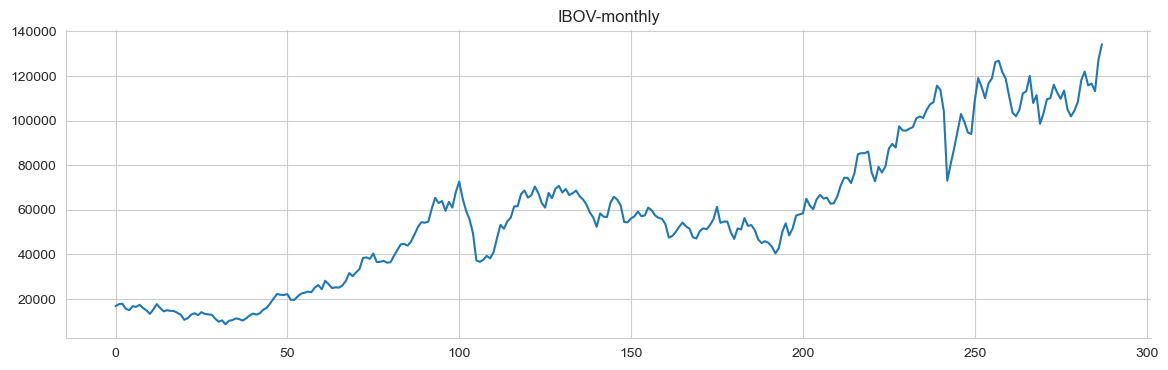

In [8]:
#===============================================================================================================================
# DATA: PLOT
#===============================================================================================================================
ax = df.plot(title=seriesId, legend=False, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [9]:
#===============================================================================================================================
# DATA: SCALE - LOG
#===============================================================================================================================
df_temp = df.copy()
df_temp['Close'] = np.log(df_temp['Close'])
df_temp

,Date,Close
0,28/01/2000,9.725221
1,29/02/2000,9.779069
2,31/03/2000,9.788097
3,28/04/2000,9.651018
4,31/05/2000,9.612909
...,...,...
283,31/08/2023,11.659117
284,29/09/2023,11.666206
285,31/10/2023,11.636414
286,30/11/2023,11.754546


In [10]:
#===============================================================================================================================
# DATA: SCALE - LOGDIFF
#===============================================================================================================================
df_scaled = df.copy()
df_scaled['Close'] = 0
df_scaled.loc[1:, ['Close']] = df_temp.loc[:, 'Close'].diff()
df_scaled

#df_scaled.describe()

,Date,Close
0,28/01/2000,0.000000
1,29/02/2000,0.053848
2,31/03/2000,0.009029
3,28/04/2000,-0.137079
4,31/05/2000,-0.038110
...,...,...
283,31/08/2023,-0.052192
284,29/09/2023,0.007089
285,31/10/2023,-0.029792
286,30/11/2023,0.118133


In [11]:
df_temp.loc[0, 'CloseRecover'] = 0
df_temp.loc[0, 'CloseRecover'] = df_temp.loc[0,'Close']
df_temp['CloseRecover'] = df_temp.loc[0, 'CloseRecover']+df_scaled['Close'].cumsum()
#df_temp[['CloseRecover']] = df_scaled.loc[,'Close'].cumsum()
#df_temp
#df_scaled['Close'].cumsum()
#len(df_temp), len(df_scaled)
df_temp

,Date,Close,CloseRecover
0,28/01/2000,9.725221,9.725221
1,29/02/2000,9.779069,9.779069
2,31/03/2000,9.788097,9.788097
3,28/04/2000,9.651018,9.651018
4,31/05/2000,9.612909,9.612909
...,...,...,...
283,31/08/2023,11.659117,11.659117
284,29/09/2023,11.666206,11.666206
285,31/10/2023,11.636414,11.636414
286,30/11/2023,11.754546,11.754546


In [12]:
#df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
#df.set_index('Date', inplace=True)

df_scaled['Date']= pd.to_datetime(df_scaled['Date'], format='%d/%m/%Y')
df_scaled.set_index('Date', inplace=True)
df_scaled


,Close
Date,
2000-01-28,0.000000
2000-02-29,0.053848
2000-03-31,0.009029
2000-04-28,-0.137079
2000-05-31,-0.038110
...,...
2023-08-31,-0.052192
2023-09-29,0.007089
2023-10-31,-0.029792


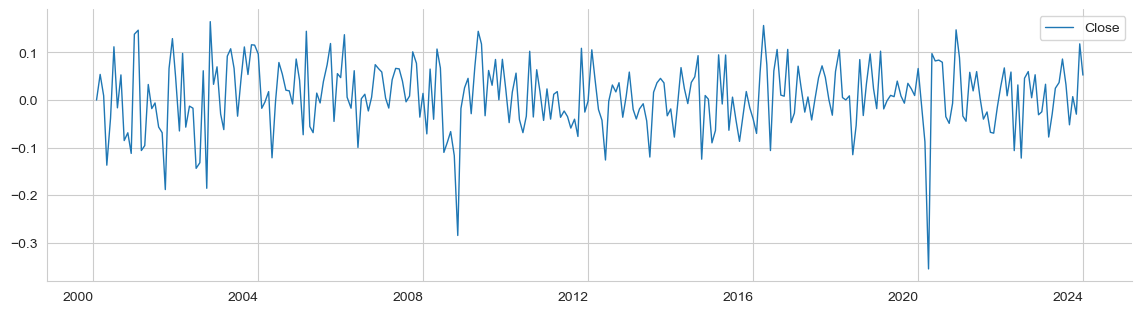

In [13]:
#===============================================================================================================================
# DATA: LOG - PLOT
#===============================================================================================================================
ax = df_scaled.plot(lw=1, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [14]:
#===============================================================================================================================
# DATA: PREP - RECURRENT SEQUENCES - FUNCTION
#===============================================================================================================================
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    #y = data[window_size-1:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    #X = np.hstack(tuple([data[i: n-j+1, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [15]:
#===============================================================================================================================
# DATA: PREP - SEQUENCES
#===============================================================================================================================
X, y = create_univariate_rnn_data(df_scaled, window_size=window_size)
X


,0,1,2,3,4,5
Date,,,,,,
2000-07-31,0.000000,0.053848,0.009029,-0.137079,-0.038110,0.111928
2000-08-31,0.053848,0.009029,-0.137079,-0.038110,0.111928,-0.016476
2000-09-29,0.009029,-0.137079,-0.038110,0.111928,-0.016476,0.052797
2000-10-31,-0.137079,-0.038110,0.111928,-0.016476,0.052797,-0.085299
2000-11-30,-0.038110,0.111928,-0.016476,0.052797,-0.085299,-0.068944
...,...,...,...,...,...,...
2023-08-31,-0.077879,-0.029495,0.024715,0.036696,0.086193,0.032132
2023-09-29,-0.029495,0.024715,0.036696,0.086193,0.032132,-0.052192
2023-10-31,0.024715,0.036696,0.086193,0.032132,-0.052192,0.007089


In [16]:
#===============================================================================================================================
# DATA: PREP - SPLIT
#===============================================================================================================================
X_train = X[:'2022'].values.reshape(-1, window_size, 1)
y_train = y[:'2022']

# keep the last year for testing
X_test = X['2023':].values.reshape(-1, window_size, 1)
y_test = y['2023':]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((270, 6, 1), (270, 1), (12, 6, 1), (12, 1))

In [17]:
#===============================================================================================================================
# DATA: PREP - OBS, WINDOWS, FEATURES
#===============================================================================================================================
n_obs, window_size, n_features = X_train.shape
n_obs, window_size, n_features

(270, 6, 1)

In [18]:
#===============================================================================================================================
# MODEL: CONFIG - LSTM
#===============================================================================================================================
rnn = Sequential([
    LSTM(units=10, input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
#===============================================================================================================================
# MODEL: CONFIG - OPTIMIZER
#===============================================================================================================================
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, weight_decay=0.0)

rnn.compile(loss='mean_squared_error', optimizer=optimizer)

rnn_path = (results_path / 'Montlhy-Ln-rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path, verbose=1, monitor='val_loss', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [20]:
#===============================================================================================================================
# MODEL: TRAIN
#===============================================================================================================================
lstm_training = rnn.fit(X_train, y_train, epochs=150, batch_size=12, shuffle=True, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stopping, checkpointer],verbose=1)

Epoch 1/150

12/23 [==============>...............] - ETA: 0s - loss: 0.0053 
Epoch 1: val_loss improved from inf to 0.00291, saving model to Data/Output/LSTM-Jansen-LnDiff-Montlhy\Montlhy-Ln-rnn.h5
23/23 [==============================] - 3s 36ms/step - loss: 0.0053 - val_loss: 0.0029
Epoch 2/150
13/23 [===============>..............] - ETA: 0s - loss: 0.0059
Epoch 2: val_loss did not improve from 0.00291
23/23 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0030
Epoch 3/150
12/23 [==============>...............] - ETA: 0s - loss: 0.0059
Epoch 3: val_loss did not improve from 0.00291
23/23 [==============================] - 0s 7ms/step - loss: 0.0052 - val_loss: 0.0030
Epoch 4/150
13/23 [===============>..............] - ETA: 0s - loss: 0.0055
Epoch 4: val_loss did not improve from 0.00291
23/23 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0030
Epoch 5/150
21/23 [==========================>...] - ETA: 0s - loss: 0.0053
Epoch 5

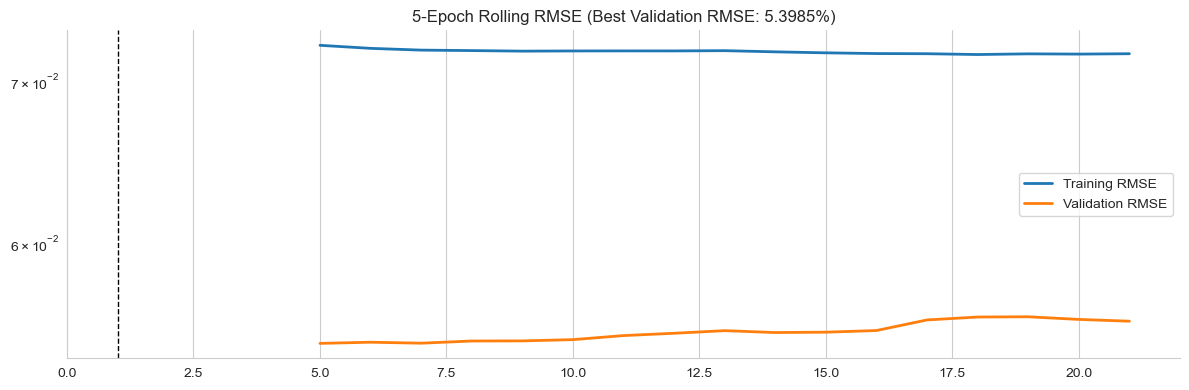

In [21]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

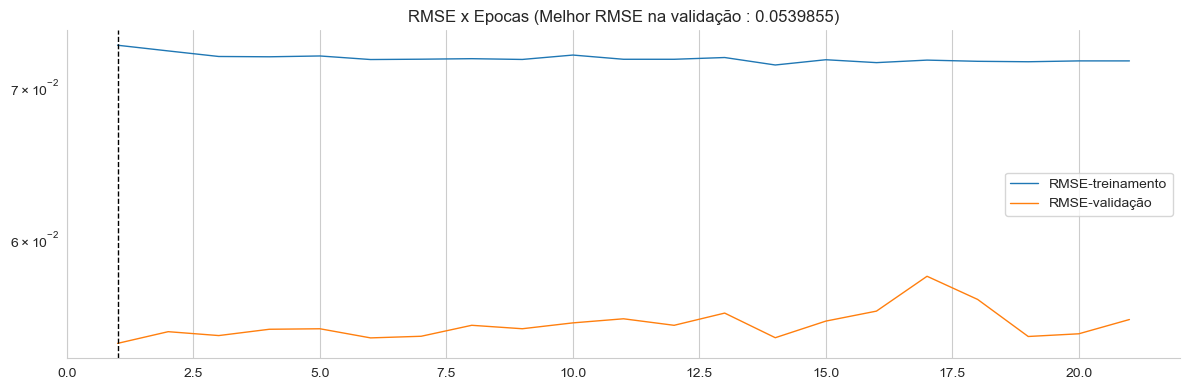

In [22]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'RMSE x Epocas (Melhor RMSE na validação : {best_rmse:.6})'
loss_history.columns=['RMSE-treinamento', 'RMSE-validação']
loss_history.rolling(1).mean().plot(logy=True, lw=1, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

In [23]:
#===============================================================================================================================
# RESULTS - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train RMSE: 0.1056 | Test RMSE: 0.1074
#-------------------------------------------------------------------------------------------------------------------------------

Train RMSE: 0.0724 | Test RMSE: 0.0540


In [24]:
#===============================================================================================================================
# RESULTS - FORECAST - TRAIN, TEST
#===============================================================================================================================
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

1/1 [==============================] - 0s 31ms/step


In [25]:
#===============================================================================================================================
# RESULTS - SPEARMAN IC - TRAIN, TEST
#===============================================================================================================================
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.6f} | Test IC: {test_ic:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train IC: 0.978179 | Test IC: 0.5664
#-------------------------------------------------------------------------------------------------------------------------------

Train IC: -0.003213 | Test IC: 0.1958


In [26]:
train_predict_scaled

array([[ 0.01527986],
       [ 0.01590341],
       [ 0.01407376],
       [ 0.01829963],
       [ 0.01925225],
       [ 0.02354068],
       [ 0.01765324],
       [ 0.01030144],
       [ 0.01650486],
       [ 0.01963755],
       [ 0.01660105],
       [ 0.01580691],
       [ 0.01794248],
       [ 0.02205214],
       [ 0.02265268],
       [ 0.0291696 ],
       [ 0.02432393],
       [ 0.01675019],
       [ 0.01381959],
       [ 0.01608771],
       [ 0.01059989],
       [ 0.01150295],
       [ 0.01386941],
       [ 0.0167878 ],
       [ 0.02408117],
       [ 0.02802332],
       [ 0.02446546],
       [ 0.03081132],
       [ 0.02072931],
       [ 0.01765585],
       [ 0.01183519],
       [ 0.01183781],
       [ 0.01625203],
       [ 0.00959875],
       [ 0.00797891],
       [ 0.00651056],
       [ 0.01050801],
       [ 0.00898714],
       [ 0.0042993 ],
       [ 0.00499532],
       [ 0.00302707],
       [ 0.00072702],
       [-0.0017222 ],
       [ 0.00275698],
       [ 0.006959  ],
       [ 0

In [27]:
#===============================================================================================================================
# RESULTS - FORECAST - SCALED - TEST 
#===============================================================================================================================
np.savetxt('Data/Output/LSTM-Jansen-Montlhy-LnDiff-Scaled-Train.txt', train_predict_scaled, delimiter=';')
np.savetxt('Data/Output/LSTM-Jansen-Montlhy-LnDiff-Scaled-Test.txt ', test_predict_scaled , delimiter=';')
test_predict_scaled[:,0]

array([0.0141169 , 0.01359252, 0.0184129 , 0.01942232, 0.01837469,
       0.01573837, 0.01138491, 0.01088568, 0.01300961, 0.01285217,
       0.01515412, 0.01053903], dtype=float32)

In [28]:
X_train

array([[[ 0.        ],
        [ 0.05384764],
        [ 0.00902866],
        [-0.13707929],
        [-0.03810955],
        [ 0.11192763]],

       [[ 0.05384764],
        [ 0.00902866],
        [-0.13707929],
        [-0.03810955],
        [ 0.11192763],
        [-0.0164759 ]],

       [[ 0.00902866],
        [-0.13707929],
        [-0.03810955],
        [ 0.11192763],
        [-0.0164759 ],
        [ 0.05279721]],

       ...,

       [[-0.10650142],
        [ 0.03169907],
        [-0.12220063],
        [ 0.0458443 ],
        [ 0.05980683],
        [ 0.00468129]],

       [[ 0.03169907],
        [-0.12220063],
        [ 0.0458443 ],
        [ 0.05980683],
        [ 0.00468129],
        [ 0.05309503]],

       [[-0.12220063],
        [ 0.0458443 ],
        [ 0.05980683],
        [ 0.00468129],
        [ 0.05309503],
        [-0.03108094]]])

In [29]:
#===============================================================================================================================
# RESULTS - RECOVER - LN - TRAIN
#===============================================================================================================================
#train_predict = pd.Series(np.exp(train_predict_scaled[:,0]), index=y_train.index)

train_predict[0] = df_temp.loc[5,'Close'] 
train_predict = train_predict[0] + train_predict_scaled.cumsum()
train_predict

NameError: name 'train_predict' is not defined

In [ ]:
#===============================================================================================================================
# RESULTS - RECOVER - LN - TEST
#===============================================================================================================================
#test_predict  = pd.Series(np.exp(test_predict_scaled[:,0]), index=y_test.index)
test_predict = df_temp.loc[275,'Close'] + test_predict_scaled.cumsum()

test_predict

In [ ]:
np.savetxt('Data/Output/LSTM-Jansen-Montlhy-LnDiff-Train.txt', train_predict, delimiter=';')
np.savetxt('Data/Output/LSTM-Jansen-Montlhy-LnDiff-Test.txt ', test_predict , delimiter=';')

In [ ]:
#===============================================================================================================================
# RESULTS - PRICE - RECOVER - TARGET - TRAIN, TEST
#===============================================================================================================================
y_train_rescaled = np.exp(y_train['Close'])
y_test_rescaled  = np.exp(y_test['Close'])

y_test_rescaled

In [ ]:
#===============================================================================================================================
# RESULTS - PRICE - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
print(f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}')

#-------------------------------------------------------------------------------------------------------------------------------
# Train RMSE: 6111.18 | Test RMSE: 12355.51
#-------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#===============================================================================================================================
# RESULTS - PRICE - STORE - TRAIN, TEST
#===============================================================================================================================
df['Train Predictions'] = train_predict
df['Test Predictions'] = test_predict

temp = pd.concat([train_predict.to_frame('predictions').assign(data='Train'), test_predict.to_frame('predictions').assign(data='Test')])
df['predictions'] = temp['predictions']
df['data']        = temp[ 'data']

df['2022-12-29':]

In [ ]:
#===============================================================================================================================
# RESULTS - PRICE - EXPORT
#===============================================================================================================================
df.to_excel('Data/Output/LSTM-Jansen-Montlhy-Ln.xlsx')

In [ ]:
#===============================================================================================================================
# DATA: LOG - PLOT
#===============================================================================================================================
ax = df_scaled.plot(lw=1, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [ ]:
#===============================================================================================================================
# RESULTS - PRICE - PLOT
#===============================================================================================================================
fig=plt.figure(figsize=(14,7))

ax1 = plt.subplot(221)
df.loc['2000':, 'Close'].plot(lw=2, ax=ax1, c='k')
df.loc['2000':, 'predictions'].plot(lw=1.5, ax=ax1, c='k')
df.loc['2000':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Close', y='predictions', data=df, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_regression', dpi=300);
